<a href="https://colab.research.google.com/github/hisics/-datawhisperers_final-project_dsml2021/blob/sushma/datawhisperers_sentiment_analysis_amazon_apparel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - ML on Apparel Reviews at Amazon US
The Data Whisperers Team ✨  Amba | Bhavya | Sushma | Heba

#### Chosen project : Option 8 - Sentiment Analysis for Ecommerce

From Dany: Look at this document for reference,<br/>
https://colab.research.google.com/drive/1g6ZtYOOhGUj1WsiPpeaVPp5T7VFw234e?usp=sharing

DATA COLUMNS:
* marketplace       : 2 letter country code of the marketplace where the review was written.
*customer_id       : Random identifier that can be used to aggregate *reviews written by a single author.
*review_id         : The unique ID of the review.
*product_id        : The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
*product_parent    : Random identifier that can be used to aggregatereviews for the same product.
*product_title     : Title of the product.
*product_category  : Broad product category that can be used to group reviews  (also used to group the dataset into coherent parts).
*star_rating       : The 1-5 star rating of the review.
*helpful_votes     : Number of helpful votes.
*total_votes       : Number of total votes the review received.
*vine              : Review was written as part of the Vine program.
*verified_purchase : The review is on a verified purchase.
*review_headline   : The title of the review.
*review_body       : The review text.
*review_date       : The date the review was written.

#### Importing libaries and Apparel dataset

In [24]:
# (1) Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# Using textblob to generate sentiment for easy visualization
from textblob import TextBlob


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch #the pytorch library, used for modeling and formatting our data to be compatible in a pytorch environment
import pandas as pd #for dataframe reading, cleaning functions
from tqdm.notebook import tqdm #used as a progress bar

%matplotlib inline

In [25]:
# (2) Download product reviews from Amazon Datasets
# You can use reviews from Amazon Datasets for a particular product.
# Note that the data are quite large so do not run this cell unless you are willing to wait!
# For reference, visit:
# https://www.tensorflow.org/datasets/catalog/amazon_us_reviews
# https://s3.amazonaws.com/amazon-reviews-pds/readme.html
!curl -O https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  618M  100  618M    0     0  41.4M      0  0:00:14  0:00:14 --:--:-- 43.2M


In [26]:
!echo "y" | gzip -d amazon_reviews_us_Apparel_v1_00.tsv.gz

gzip: amazon_reviews_us_Apparel_v1_00.tsv already exists;	not overwritten


In [27]:
# (3.a) Read the contents of the folder 
!ls

amazon_reviews_us_Apparel_v1_00.tsv	Emoji_Dict.p	 sample_data
amazon_reviews_us_Apparel_v1_00.tsv.gz	Emoticon_Dict.p


In [28]:
# (3.b) Explore data (see what is categorial and numerical)

In [29]:
df = pd.read_table('amazon_reviews_us_Apparel_v1_00.tsv', delim_whitespace=False, error_bad_lines=False, nrows=50000)
df.info()

b'Skipping line 49396: expected 15 fields, saw 22\n'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        50000 non-null  object
 1   customer_id        50000 non-null  int64 
 2   review_id          50000 non-null  object
 3   product_id         50000 non-null  object
 4   product_parent     50000 non-null  int64 
 5   product_title      50000 non-null  object
 6   product_category   50000 non-null  object
 7   star_rating        50000 non-null  int64 
 8   helpful_votes      50000 non-null  int64 
 9   total_votes        50000 non-null  int64 
 10  vine               50000 non-null  object
 11  verified_purchase  50000 non-null  object
 12  review_headline    50000 non-null  object
 13  review_body        49975 non-null  object
 14  review_date        49999 non-null  object
dtypes: int64(5), object(10)
memory usage: 5.7+ MB


In [30]:
# To see how the data looks like and if any is boolean
df.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
49995,US,20149764,R1ZPAKQP5VCKW0,B00XLGK7LW,912672661,2pk Men’s Authentic Crisp Printed Boxer Briefs...,Apparel,4,0,0,N,Y,... they are but for the most part they are nice.,I thought the quality would've been thicker th...,2015-06-19
49996,US,838773,R3U1GQNU0C479H,B00XLGK6SQ,912672661,2pk Men’s Authentic Crisp Printed Boxer Briefs...,Apparel,5,0,0,N,Y,Comfortable,the comfortable pair of boxer briefs I have!,2015-07-26
49997,US,183721,R2AM5DJS8YZ41S,B00XLGK6SQ,912672661,2pk Men’s Authentic Crisp Printed Boxer Briefs...,Apparel,4,0,0,N,Y,Four Stars,So nice,2015-08-02
49998,US,1090724,R2MGN5V491GVSV,B00XLGK42Y,912672661,2pk Men’s Authentic Crisp Printed Boxer Briefs...,Apparel,5,0,0,N,Y,"I love em, they are comfortable","I love em, they are comfortable, fashionable ...",2015-07-18
49999,US,122982,RHE3YQC9E1A82,B00XLGACWG,848337177,Floral 50s Swing Rockabilly Party Halter Prom ...,Apparel,5,0,0,N,N,she looks beautiful in it,"Bought for my 16 year old daughter, she looks ...",2015-08-12


###Cleaning data and converting data types


#### Pre-processing the columns without review text

In [31]:
# Checking if marketplace is only in the US
df.marketplace.unique()

array(['US'], dtype=object)

In [32]:
# creating numerical df -> df_num
# creating categorical df -> df_cat
cat_list = ['marketplace','review_id','product_id','product_title','product_category','vine','verified_purchase','review_headline','review_body','review_date']
df_num = df.drop(cat_list, inplace = False , axis = 1) 

df_cat = df[cat_list]


# Cleaning
# (1) Drop: marketplace + product_category + review_id
df.drop(['marketplace','product_category','review_id'], axis=1, inplace=True)

# (2) Map: vine + verified_purchase (y:1, n:0)
YN_to_bool = {'Y': 1,'N': 0}
df['vine'] = df['vine'].map( YN_to_bool )
df['verified_purchase'] = df['verified_purchase'].map( YN_to_bool)

# (3) Datetime: review_date
df['review_date'] = pd.to_datetime(df['review_date'])

# (4) Create a year column for EDA
df['Year'] = df.review_date.dt.year

# (5) Drop the rows where there are no reviews
df.dropna(subset = ['review_body'], inplace = True)

 
# (6) Combine the review headline and review date columns
df['review_body'] = df['review_headline'] + ' ' + df['review_body']
del df['review_headline']

df.head(1)

,customer_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_body,review_date,Year
0,32158956,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,4,0,0,0,1,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...,2013-01-14,2013.0


#### Pre-processing the text fields
##### Useful resource for cleaning text
https://medium.com/mlearning-ai/10-python-functions-you-need-to-apply-before-you-build-your-nlp-sentiment-analysis-model-874a37e0217e

In [33]:
# Removing the hashtags
import re      # Import REGEX
def remove_mentions(text):
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  return text

df['review_body'] = df.apply(lambda row: remove_mentions(row['review_body']), axis=1)

In [34]:
# Removing the emojis |

# # Reference code: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# def remove_emoji(review_body):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

In [35]:
# Importing text cleaning libraries 
# Tokenizer: Tokenization of data. At one stage we will need to deal with our text as a words list to iterate between the words and apply certain functions on it

import nltk         #Natural language processing tool-kit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [36]:
# lower all upper case and enumerate words into a list
df['review_body'] = df['review_body'].str.lower()
# df['review_body'] = df['review_body'].values.tolist()
df['review_body']

0        ★ these really do work great with some tweakin...
1        favorite for winter. very warm! i love this dr...
2        great socks for the money. nice socks, great c...
3        slick hat! i bought this for my husband and wo...
4        i would do it again! perfect dress and the cus...
                               ...                        
49995    ... they are but for the most part they are ni...
49996    comfortable the comfortable pair of boxer brie...
49997                                   four stars so nice
49998    i love em, they are comfortable i love em,  th...
49999    she looks beautiful in it bought for my 16 yea...
Name: review_body, Length: 49975, dtype: object

In [37]:
# Removal of numbers and digits
import re      # Import REGEX
def remove_numbers(text):
  text = re.sub(r'\d+', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_numbers(row['review_body']), axis=1)


In [38]:
# Removal of special characters
import re, string, unicodedata # Import Regex, string and unicodedata.
def remove_non_ascii(words):
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return words

df['review_body'] = df.apply(lambda row: remove_non_ascii(row['review_body']), axis=1)

In [39]:
# Removal of punctuation
import re      # Import REGEX
def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', '', str(text))
  return text

df['review_body'] = df.apply(lambda row: remove_punctuation(row['review_body']), axis=1)


In [40]:
# Import nltk stop words
# # Removal of stop words
import nltk
from nltk.corpus import stopwords            #Stopwords corpus
stopwords = stopwords.words('english')

In [41]:
# Customising the stop words - we need to review this
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# # Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

In [42]:
# after cleaning text, bring the words into a list
df['review_body'] = df.apply(lambda row: nltk.word_tokenize(row['review_body']), axis=1)
df['review_body']

0        [these, really, do, work, great, with, some, t...
1        [favorite, for, winter, very, warm, i, love, t...
2        [great, socks, for, the, money, nice, socks, g...
3        [slick, hat, i, bought, this, for, my, husband...
4        [i, would, do, it, again, perfect, dress, and,...
                               ...                        
49995    [they, are, but, for, the, most, part, they, a...
49996    [comfortable, the, comfortable, pair, of, boxe...
49997                              [four, stars, so, nice]
49998    [i, love, em, they, are, comfortable, i, love,...
49999    [she, looks, beautiful, in, it, bought, for, m...
Name: review_body, Length: 49975, dtype: object

In [43]:
!pip install emot
!from emot import emo_unicode

from: can't read /var/mail/emot


In [44]:
import re
import pickle
from emot import emo_unicode
# from emot.emo_unicode import UNICODE_EMO, EMOTICONS

In [45]:
# def remove_emoji(string):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F" # emoticons
#                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF" # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

# print(remove_emoji("Hilarious 😂! The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"))

In [46]:
# Create function to replace emoji to word
import pickle
import re

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

text = "I won 🥇 in 🏏"
convert_emojis_to_word(text)
convert_emojis_to_word("I like to eat 🍕")

'I like to eat pizza'

In [47]:
# # Apply convert emoji function to review body
# df['review_body'] = df.apply(lambda row: convert_emojis_to_word(row['review_body']), axis=1)
# df['review_body']

In [48]:
# Function to convert Emoticons to word
import re
try:
    import cPickle as pickle
except ImportError:
    import pickle  

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def convert_emoticons(text):
   for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', "_".join(Emoticon_Dict[emot].replace(",","").split()), text)
   return text

# Example
text = "Hello :-) :-)"
convert_emoticons(text)


'Hello Happy_face_smiley Happy_face_smiley'

In [49]:
# # Apply convert Emoticons function to review body
# df['review_body'] = df.apply(lambda row: convert_emoticons(row['review_body']), axis=1)
# df['review_body']

### EDA and Feature Engineering

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49975 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        49975 non-null  int64         
 1   product_id         49975 non-null  object        
 2   product_parent     49975 non-null  int64         
 3   product_title      49975 non-null  object        
 4   star_rating        49975 non-null  int64         
 5   helpful_votes      49975 non-null  int64         
 6   total_votes        49975 non-null  int64         
 7   vine               49975 non-null  int64         
 8   verified_purchase  49975 non-null  int64         
 9   review_body        49975 non-null  object        
 10  review_date        49974 non-null  datetime64[ns]
 11  Year               49974 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 5.0+ MB


In [51]:
# Quick check: Using discriptive statistics + measures of dispersion
# Note: customer_id and product_parent are random numbers not for descriptive analysis
df_discriptive = df.drop(['customer_id','product_parent'],axis = 1,inplace = False)
df_discriptive.describe()

,star_rating,helpful_votes,total_votes,vine,verified_purchase,Year
count,49975.000000,49975.000000,49975.000000,49975.000000,49975.000000,49974.000000
mean,3.969705,1.649765,1.951696,0.000400,0.839880,2014.999120
std,1.401379,9.554821,10.071362,0.020001,0.366721,0.055144
min,1.000000,0.000000,0.000000,0.000000,0.000000,2008.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000,2015.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000,2015.000000
75%,5.000000,1.000000,1.000000,0.000000,1.000000,2015.000000
max,5.000000,628.000000,634.000000,1.000000,1.000000,2015.000000


In [52]:
df.groupby('star_rating').mean()

,customer_id,product_parent,helpful_votes,total_votes,vine,verified_purchase,Year
star_rating,,,,,,,
1,2.144042e+07,5.117550e+08,1.595279,2.238111,0.000170,0.873471,2015.000000
2,2.273159e+07,5.050320e+08,1.060511,1.407816,0.000315,0.942326,2015.000000
3,2.230190e+07,5.136141e+08,1.623901,1.935452,0.000200,0.928257,2014.999800
4,2.232619e+07,5.030379e+08,1.654935,1.888942,0.000713,0.877765,2014.999168
5,2.145717e+07,5.037303e+08,1.732545,1.975273,0.000400,0.793200,2014.998691


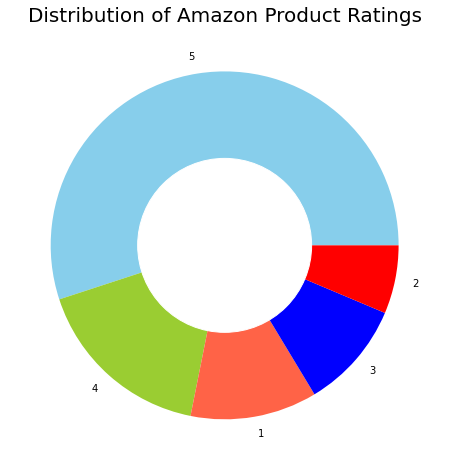

In [53]:
# Distribution of Amazon Product Ratings
ratings = df["star_rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(10, 8))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Distribution of Amazon Product Ratings", fontsize=20)
plt.show()

In [54]:
#  Classify rating to Rating class
df["classes"] = df["star_rating"]
df["classes"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["classes"].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49975 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        49975 non-null  int64         
 1   product_id         49975 non-null  object        
 2   product_parent     49975 non-null  int64         
 3   product_title      49975 non-null  object        
 4   star_rating        49975 non-null  int64         
 5   helpful_votes      49975 non-null  int64         
 6   total_votes        49975 non-null  int64         
 7   vine               49975 non-null  int64         
 8   verified_purchase  49975 non-null  int64         
 9   review_body        49975 non-null  object        
 10  review_date        49974 non-null  datetime64[ns]
 11  Year               49974 non-null  float64       
 12  classes            49975 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(7), object(4)
memory 

In [56]:
#Figuring out the distribution of Ratings
df['classes'].value_counts()

positive    35910
negative     9061
neutral      5004
Name: classes, dtype: int64

In [57]:
# (4) Choose the label and features

# Select the features
selectedFeatures = ['product_id','star_rating', 'total_votes', 'helpful_votes','vine','verified_purchase']
features = df.loc[:, selectedFeatures]

#Apply Standarddization
# scaler = StandardScaler()
# features = scaler.fit_transform( features )

features[0:10]

,product_id,star_rating,total_votes,helpful_votes,vine,verified_purchase
0,B01KL6O72Y,4,0,0,0,1
1,B01ID3ZS5W,5,2,1,0,1
2,B01I497BGY,5,0,0,0,1
3,B01HDXFZK6,5,0,0,0,1
4,B01G6MBEBY,5,0,0,0,1
5,B01FWRXN0Y,5,0,0,0,1
6,B01EXNH1HE,5,0,0,0,1
7,B01E7OL09O,4,0,0,0,1
8,B01DXHX81O,5,0,0,0,1
9,B01DDULIJK,3,0,0,0,1


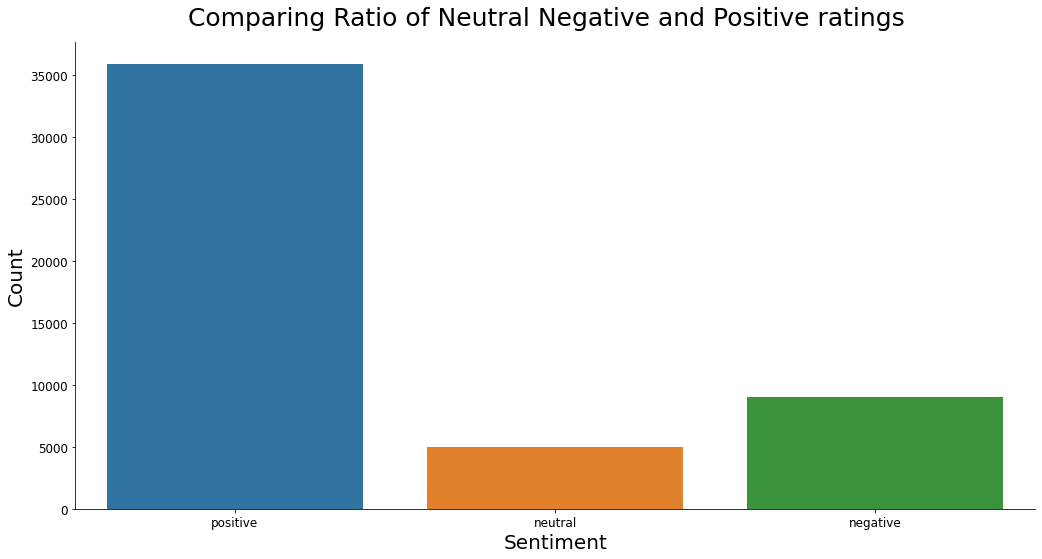

In [58]:
# (5) Feature engineer for data that is
# (a) relevant 
# (b) unique
# (c) correct 
# (d) not missing

# Drop data that is not a,b,c, or d
# Use one-hot encoding for nominal
# Reduce dimensions of your features

# Put features into dataframe
# Distribution of sentiment class
fig, axes = plt.subplots(1, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive ratings", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "classes", data = df)
axes.set_xlabel("Sentiment", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
sns.despine()

In [59]:
# Group by product and Rating class
df.groupby("product_id")["classes"].unique()

product_id
B00XLGACWG    [positive]
B00XLGK42Y    [positive]
B00XLGK6SQ    [positive]
B00XLGK7LW    [positive]
B00XLGK8QG    [positive]
                 ...    
B01G6MBEBY    [positive]
B01HDXFZK6    [positive]
B01I497BGY    [positive]
B01ID3ZS5W    [positive]
B01KL6O72Y    [positive]
Name: classes, Length: 35026, dtype: object

### Popular words in Review


In [60]:
pos = df_discriptive.loc[df['classes'] == 'positive']
pos = pos[0:25000]

neg = df.loc[df['classes'] == 'negative']
neg = neg[0:25000]

In [61]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt


def create_Word_Corpus(temp):
    words_corpus = ''
    for val in temp["review_body"]:
        text = str(val).lower()
        #text = text.translate(trantab)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus
        
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

In [62]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

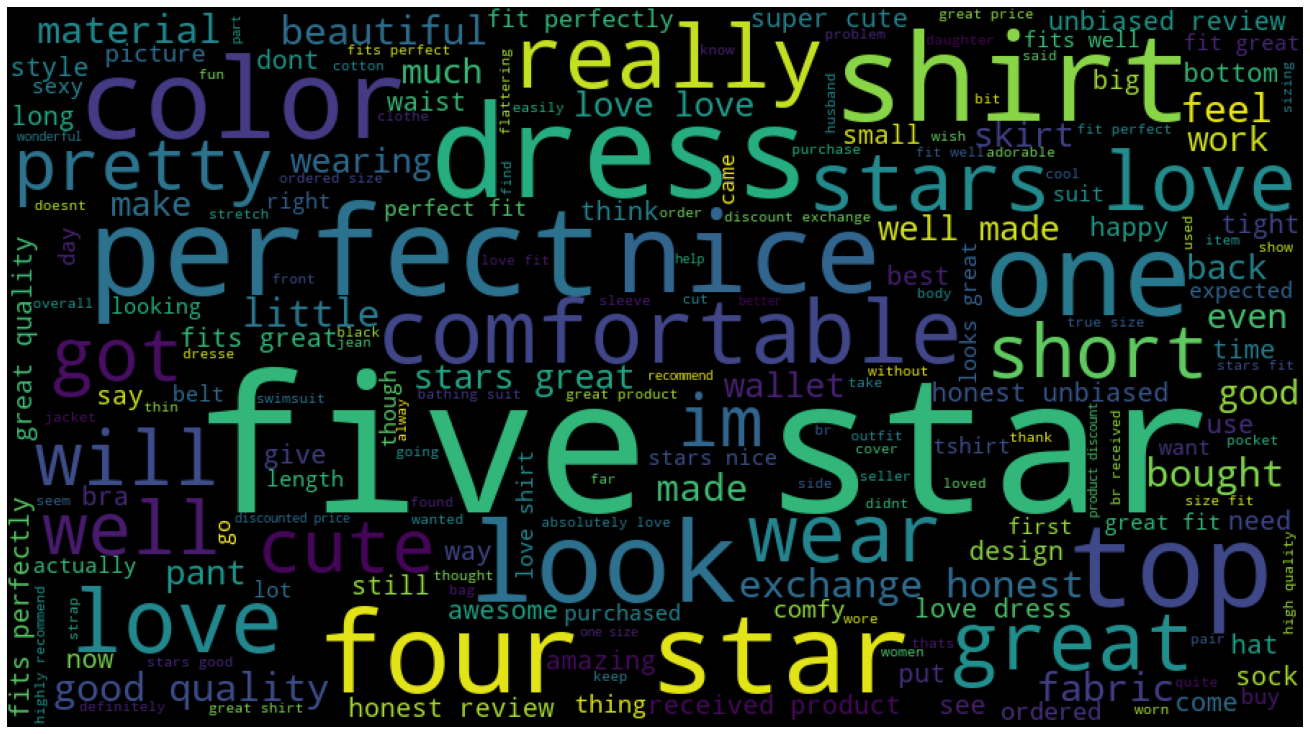

In [63]:
#Visuallizing popular positive words
plot_Cloud(pos_wordcloud)

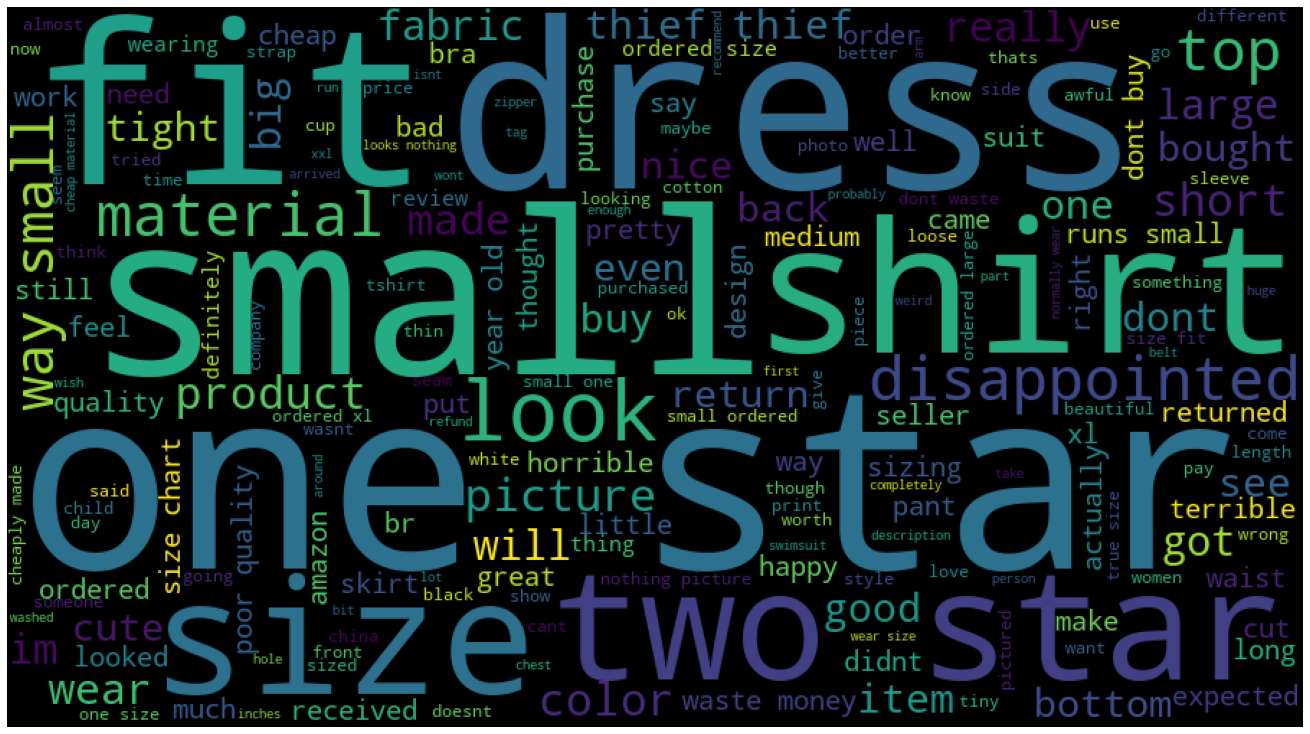

In [64]:
#Visuallizing popular negative words
plot_Cloud(neg_wordcloud)

### Word Count per Review type

In [65]:
from textblob import TextBlob
df['text_word_count']= df.apply(lambda row: len(row['review_body']), axis=1)
# df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))


In [67]:
df[df.star_rating==5].text_word_count.median()

19.0

In [68]:
df[df.star_rating==4].text_word_count.median()

28.0

In [69]:
df[df.star_rating==3].text_word_count.median()

29.0

In [70]:
df[df.star_rating==2].text_word_count.median()

29.0

In [71]:
df[df.star_rating==1].text_word_count.median()

24.0

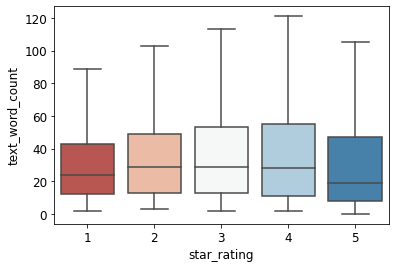

In [72]:
sns.boxplot(x='star_rating',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

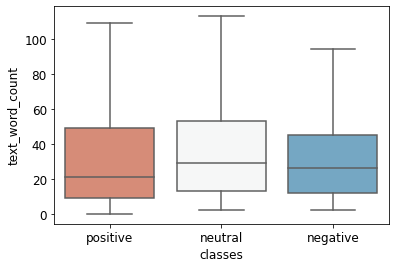

In [73]:
sns.boxplot(x='classes',y='text_word_count', data=df, palette='RdBu', showfliers=False)
plt.show()

In [74]:
# (6) Confirm data is ready with further exploratory analysis

In [75]:
# (7) Training, Testing (and/or Validation) data split 

# for example, 60/20/20

In [76]:
# (7.b) If using Deep Learning, building the model

# Add Input Layer
# Add Hidden Layers
# Add Output

In [77]:
# (8) Training the Machine Learning Model (i.e, Fitting the Model)

In [78]:
# (9) Evaluate the model metrics for Training (and/or Validation) data

In [79]:
# (10) Evaluate the model metris for Testing data


# If metrics are poor, optimize either (a) the data, (b) the hyperpamaters

In [80]:
# (11) Use the model for prediction

In [81]:
# (12) Write final predicted data  (e.g, to CSV or JSON, etc.)